# GNN Static Fingerspelling Recognition

In [48]:
!lscpu
!nvidia-smi -L

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   4
  On-line CPU(s) list:    0-3
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.00GHz
    CPU family:           6
    Model:                85
    Thread(s) per core:   2
    Core(s) per socket:   2
    Socket(s):            1
    Stepping:             3
    BogoMIPS:             4000.36
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge m
                          ca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht sysc
                          all nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xt
                          opology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq
                           ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt
                           aes xsave avx f16c rdrand hypervisor 

In [3]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.3 MB/s eta 0:00:0000:0100:01


In [4]:
SEED = 42

import os
import math
import random

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

!python --version
print(f"torch version: {torch.__version__}")

Python 3.10.14
torch version: 2.4.0


# Raw Dataset

In [5]:
import string

possible_categories = [letter.lower() for i, letter in enumerate(string.ascii_uppercase) if letter not in ['J', 'Z']]
#possible_categories.append("*") # unknown symbol
#possible_categories.extend([str(x) for x in range(0, 10)]) # digits 0-9

def load_dataset_from_csv(path, *, keep_every=1, possible_categories=possible_categories):
    df = pd.read_csv(path, dtype={63: str}, header=None)
    df = df[df[63].notna() & df[63].apply(lambda l: str(l).lower()).isin(possible_categories)]
    if keep_every > 1:
        df = df[df.index % keep_every == 0]
    df[63] = df[63].apply(lambda l: l.lower())
    df.columns = [f"{coord}_dominant_hand_{i}" for i in range(21) for coord in ["x", "y", "z"]] + [63]
    return df

In [6]:
DATASET_FOLDER = "/kaggle/input/tdk-v2-static"

In [8]:
import os

# Load own dataset
my_dataset = load_dataset_from_csv(os.path.join(DATASET_FOLDER, "my_dataset.csv"))

# Load mnist (converted)
mnist_df = load_dataset_from_csv(os.path.join(DATASET_FOLDER, "mnist_dataset.csv"))
mnist_df = mnist_df[mnist_df[63] != "r"] # Img -> Pose struggles with 'r'

# Load exter (converted)
exter_df = pd.DataFrame()
for p in ["A", "B", "C", "D", "E"]:
    exported_df = load_dataset_from_csv(os.path.join(DATASET_FOLDER, f"exter_{p}.csv"))
    exter_df = pd.concat([exter_df, exported_df])
exter_df = exter_df[exter_df[63] != "r"] # Img -> Pose struggles with 'r'

df = pd.concat([exter_df, mnist_df, my_dataset]).reset_index(drop=True)

In [9]:
def category_distrib(df, title=""):
    category_counts = df[63].value_counts()
    plt.figure(figsize=(8, 6))
    category_counts.plot(kind='bar')
    plt.xlabel('Kategóriák', fontname="Calibri")
    plt.ylabel('Minták száma', fontname="Calibri")
    plt.title(title, fontname="Calibri")
    #plt.savefig('Distribution of training dataset Categories.png', dpi=300)  # High resolution
    plt.show()

def equalize_category_counts(df, category_column, max_size=None):
    # Group by category and find the maximum size
    if not max_size:
        max_size = df.groupby(category_column).size().min()

    # Resample each group
    resampled = [group.sample(max_size, replace=False, random_state=SEED) for _, group in df.groupby(category_column)]

    # Concatenate the resampled groups
    return pd.concat(resampled, ignore_index=True)

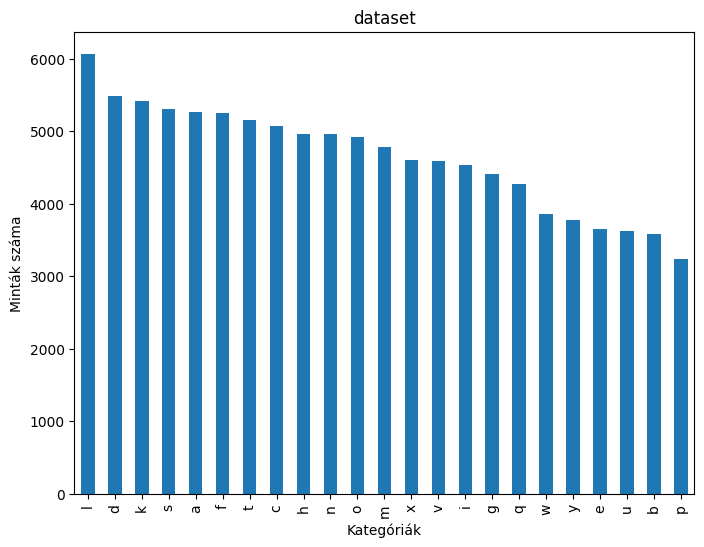

In [10]:
category_distrib(df, "dataset")

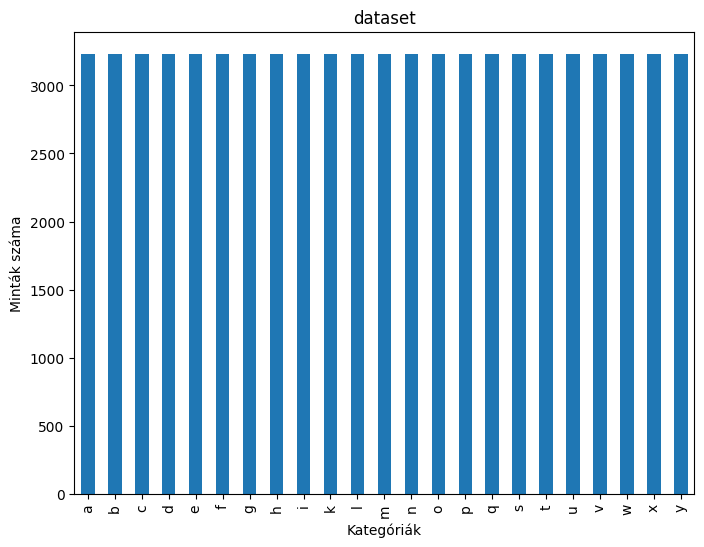

In [11]:
df = equalize_category_counts(df, 63)
category_distrib(df, "dataset")

In [12]:
df = df.sample(len(df), replace=False, random_state=SEED)
df

,x_dominant_hand_0,y_dominant_hand_0,z_dominant_hand_0,x_dominant_hand_1,y_dominant_hand_1,z_dominant_hand_1,x_dominant_hand_2,y_dominant_hand_2,z_dominant_hand_2,x_dominant_hand_3,...,x_dominant_hand_18,y_dominant_hand_18,z_dominant_hand_18,x_dominant_hand_19,y_dominant_hand_19,z_dominant_hand_19,x_dominant_hand_20,y_dominant_hand_20,z_dominant_hand_20,63
29244,0.516720,0.898206,2.388885e-06,0.313777,0.772766,-0.033415,0.296731,0.618676,-0.063025,0.428083,...,0.706178,0.555112,-0.313315,0.592088,0.633026,-0.263466,0.596579,0.690456,-0.189609,k
32320,0.752242,0.843529,3.700000e-07,0.738511,0.807791,-0.015201,0.737754,0.760241,-0.022147,0.752178,...,0.796572,0.751478,-0.030285,0.788456,0.784615,-0.028703,0.780519,0.806802,-0.022706,k
27212,0.342685,0.903137,-1.104080e-06,0.544841,0.747481,-0.055150,0.718242,0.544821,-0.079315,0.789781,...,0.174138,0.214030,-0.019928,0.181643,0.146073,0.000194,0.197853,0.109034,0.026671,i
69051,0.502115,0.647325,-1.856063e-06,0.328798,0.571366,-0.079685,0.219239,0.444155,-0.150389,0.288046,...,0.826625,0.475565,-0.307203,0.684039,0.528543,-0.260256,0.639372,0.544890,-0.191759,x
40515,0.471101,0.763630,8.760400e-07,0.625543,0.718722,-0.070818,0.772135,0.562461,-0.100401,0.792960,...,0.334026,0.346332,-0.142962,0.418023,0.428734,-0.138585,0.466464,0.520166,-0.114760,n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37194,0.708934,0.656955,-2.041292e-06,0.468399,0.564557,-0.058104,0.385843,0.413904,-0.111199,0.540964,...,0.697645,0.302236,-0.260672,0.679888,0.409177,-0.269171,0.726932,0.471108,-0.256806,m
6265,0.717921,0.891532,4.655922e-07,0.655947,0.826175,-0.028359,0.621939,0.679053,-0.042234,0.671498,...,0.754184,0.406799,-0.070898,0.748957,0.321055,-0.083862,0.743296,0.240793,-0.096242,b
54886,0.612331,0.661212,-2.859275e-06,0.396809,0.574972,-0.062269,0.233736,0.426671,-0.101191,0.253331,...,0.786716,0.258907,-0.215409,0.717653,0.361195,-0.152247,0.738842,0.408499,-0.081043,s
860,0.440668,0.603220,-2.980000e-07,0.479031,0.562884,-0.014832,0.507349,0.482958,-0.020157,0.514548,...,0.419428,0.450595,-0.025513,0.426090,0.501262,-0.022084,0.428526,0.534141,-0.014789,a


In [13]:
num_rows_with_nan = df.isnull().any(axis=1).sum()
print(f"Number of partial hands: {num_rows_with_nan}")

Number of partial hands: 0


# Graph Dataset

In [53]:
def preprocess_features(flat_xyz: np.ndarray):
    if len(flat_xyz.shape) == 1:
        flat_xyz = np.array([flat_xyz])

    batch_dim = flat_xyz.shape[0]
    xyz = flat_xyz.reshape((batch_dim, 21, 3))

    # Take only the x and y coordinates, as z only shows relative distance
    xy = xyz[:, :, :2]

    # Center the points to (0,0)
    centroids = xy.mean(axis=1, keepdims=True)
    centered_xy = xy - centroids

    # Calculate the max distance in x and y directions separately
    max_x_distances = np.max(np.abs(centered_xy[..., 0]), axis=1, keepdims=True)  # shape: (batch_dim, 1)
    max_y_distances = np.max(np.abs(centered_xy[..., 1]), axis=1, keepdims=True)  # shape: (batch_dim, 1)

    # Calculate separate scale factors for x and y directions
    scale_factors_x = 1 / max_x_distances  # shape: (batch_dim, 1)
    scale_factors_y = 1 / max_y_distances  # shape: (batch_dim, 1)

    # Scale x and y coordinates separately
    scaled_x = centered_xy[..., 0] * scale_factors_x  # shape: (batch_dim, 21)
    scaled_y = centered_xy[..., 1] * scale_factors_y  # shape: (batch_dim, 21)

    # Combine the scaled x and y coordinates
    scaled_xy = np.stack([scaled_x, scaled_y], axis=-1)  # shape: (batch_dim, 21, 2)

    # Concatenate back the z-coordinates (without scaling) to retain depth info
    xyz = np.concatenate([scaled_xy, xyz[:, :, 2:]], axis=2)
    return xyz.reshape((batch_dim, -1))

# Example usage with float_xyz
float_xyz = df.values[0][:-1].astype(np.float32)
preprocessed_xyz = preprocess_features(float_xyz)
preprocessed_xyz.shape

(1, 63)

In [54]:
# NOTE: MediaPipe Hand landmark model: https://mediapipe.readthedocs.io/en/latest/solutions/hands.html
anatomical_connections = [
    (0,1), (0,5), (0,17), (1,2), (2,3), (3,4),
    (5,6), (5,9), (6,7), (7,8), (9,10), (9,13),
    (10,11), (11,12), (13,14), (13,17), (14,15),
    (15,16), (17,18), (18,19), (19,20)
]
# Create the edge list and make it undirected by adding reverse connections (same for all graphs)
temp = []
for a, b in anatomical_connections:
    temp.append([a, b])
    temp.append([b, a])  # Add the reverse connection
anatomical_connections = temp

inverse_graph_connections = []
for i in range(21):
    for j in range(21):
        conn = (i, j)
        if conn not in anatomical_connections and i != j:
            inverse_graph_connections.append(conn)

In [55]:
from typing import List
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data, InMemoryDataset

class GraphDataset(InMemoryDataset):
    def __init__(self, df: pd.DataFrame, transform=None, pre_transform=None):
        self.label_encoder = LabelEncoder()
        # Assumed to have edges both ways between nodes when undirected
        self.connections = anatomical_connections
        # self.connections = inverse_graph_connections # Alternative Inverse Graph

        super().__init__(None, transform, pre_transform)
        self.data_list = self.process_data(df)

    def process_data(self, df: pd.DataFrame) -> List[Data]:
        # Encode the categorical column
        labels = self.label_encoder.fit_transform(df.iloc[:, -1])
        features = preprocess_features(df.values[:, :-1].astype(np.float32)).reshape((len(df), 21, 3))[:, :, :2] # NOTE use only x,y

        edge_index = torch.tensor(self.connections, dtype=torch.long).t().contiguous()

        data_list = []
        for feature, label in zip(features, labels):
            # Create the graph data object
            x = torch.tensor(feature, dtype=torch.float)
            y = torch.tensor(label, dtype=torch.long)
            data = Data(x=x, edge_index=edge_index, y=y)
            data_list.append(data)

        return data_list
    
    @property
    def num_classes(self):
        return len(set(self.label_encoder.classes_))

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

In [56]:
dataset = GraphDataset(df)

print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: GraphDataset(74359):
Number of graphs: 74359
Number of features: 2
Number of classes: 23

Data(x=[21, 2], edge_index=[2, 42], y=9)
Number of nodes: 21
Number of edges: 42
Average node degree: 2.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


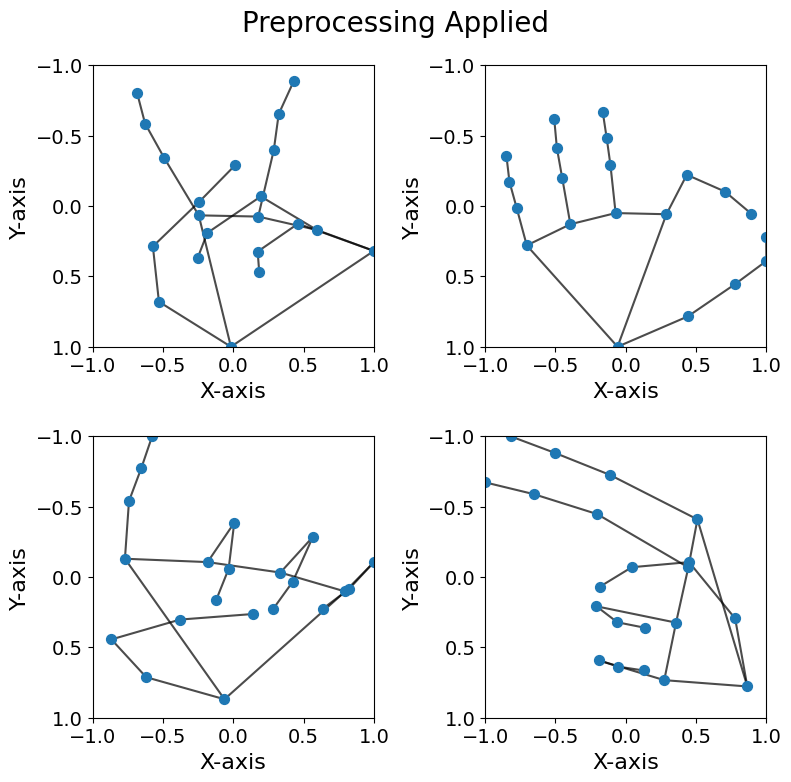

In [57]:
import networkx as nx
import matplotlib.pyplot as plt
import random

def visualize_graph_grid(dataset, grid_size=4, indices=[]):
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(4 * grid_size, 4 * grid_size))
    fig.suptitle("Preprocessing Applied", fontsize=20)

    random_indices = indices if len(indices) > 0 else random.sample(range(len(dataset)), grid_size * grid_size)

    for idx, ax in zip(random_indices, axs.flatten()):
        data = dataset[idx]
        node_features = data.x.numpy()
        edge_index = data.edge_index.numpy()

        x = node_features[:, 0]
        y = node_features[:, 1]

        G = nx.Graph()
        G.add_edges_from(edge_index.T)

        pos = {i: (x[i], y[i]) for i in range(len(x))}

        nx.draw_networkx_nodes(G, pos, node_size=50, ax=ax)
        nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7, ax=ax)

        ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.invert_yaxis()
        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize=14)
        ax.set_xlabel("X-axis", fontsize=16)
        ax.set_ylabel("Y-axis", fontsize=16)

    plt.tight_layout()
    #plt.savefig("preproc-static.png", dpi=300)
    plt.show()

visualize_graph_grid(dataset, grid_size=2, indices=[0, 890, 9295, 123])

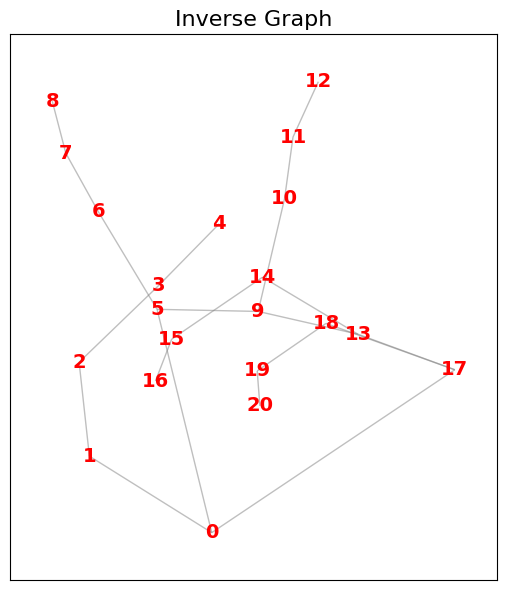

In [58]:
def visualize_single_graph(node_features, edge_index, title="Graph Visualization"):
    node_features, edge_index = node_features.numpy(), edge_index.numpy()
    
    assert node_features.shape[1] == 2, "Visualization only supports 2D datapoints"
        
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(title, fontsize=16)

    x = node_features[:, 0]
    y = node_features[:, 1]

    G = nx.Graph()
    G.add_edges_from(edge_index.T)

    pos = {i: (x[i], y[i]) for i in range(len(x))}

    # Plot nodes and edges
    # nx.draw_networkx_nodes(G, pos, node_size=50, ax=ax)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, ax=ax, edge_color="gray",)
    
    labels = {i: str(i) for i in range(len(x))}
    nx.draw_networkx_labels(G, pos, labels, font_size=14, font_weight="bold", font_color="red", ax=ax)

    ax.invert_yaxis()
    ax.set_aspect('equal', adjustable='box')

    # ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    plt.savefig("inverse_connections.png", dpi=300)
    plt.show()

visualize_single_graph(dataset[0].x, dataset[0].edge_index, title="Inverse Graph")

In [59]:
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader

# Split lengths for train (80%), test (10%), valid (10%)
train_size = int(0.8 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for step, data in enumerate(train_loader):
    if step < 3:
        print(f'Step {step + 1}:')
        print('=======')
        print(f'Number of graphs in the current batch: {data.num_graphs}')
        print(data)
        print()
    else:
        break

Step 1:
Number of graphs in the current batch: 256
DataBatch(x=[5376, 2], edge_index=[2, 10752], y=[256], batch=[5376], ptr=[257])

Step 2:
Number of graphs in the current batch: 256
DataBatch(x=[5376, 2], edge_index=[2, 10752], y=[256], batch=[5376], ptr=[257])

Step 3:
Number of graphs in the current batch: 256
DataBatch(x=[5376, 2], edge_index=[2, 10752], y=[256], batch=[5376], ptr=[257])



# GNN Models

In [84]:
from typing import Literal
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv
from torch_geometric.nn import global_mean_pool

class MyGCNConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MyGCNConv, self).__init__()
        
        self.conv = GCNConv(in_channels, out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        x = self.relu(x)
        return x
    
class MyGATConv(nn.Module):
    def __init__(self, in_channels, out_channels, attention_heads=4):
        super(MyGATConv, self).__init__()
        
        assert out_channels % attention_heads == 0
        
        self.conv = GATConv(in_channels, out_channels//attention_heads, heads=attention_heads, concat=True)
        self.combine_heads = nn.Linear(out_channels, out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        x = self.combine_heads(x)
        x = self.relu(x)
        return x
    
class MyGATv2Conv(MyGATConv):
    def __init__(self, in_channels, out_channels, attention_heads):
        super(MyGATv2Conv, self).__init__(in_channels, out_channels, attention_heads)
        self.conv = GATv2Conv(in_channels, out_channels // attention_heads, heads=attention_heads, concat=True)

class GNN(nn.Module):
    def __init__(self, num_layers, hidden_dim, ff_dim, layer_type: Literal["gcn", "gat"]):
        super(GNN, self).__init__()
        
        assert num_layers >= 1
        
        # GCN
        GNNConvLayer = MyGCNConv if layer_type == "gcn" else MyGATConv
        conv_layers = []
        conv_layers.append(GNNConvLayer(dataset.num_node_features, hidden_dim if num_layers != 1 else ff_dim))
        for i in range(1, num_layers):
            conv_layers.append(GNNConvLayer(hidden_dim, hidden_dim if i != num_layers-1 else ff_dim))
        self.graph_conv = nn.ModuleList(conv_layers)
        
        # Readout
        self.lin = Linear(ff_dim, dataset.num_classes)

    def compute_embeddings(self, x, edge_index, batch):
        """Separate this step for visualization purposes."""
        # 1. Obtain node embeddings
        for layer in self.graph_conv:
            x = layer(x, edge_index)
        return x

    def forward(self, x, edge_index, batch):
        x = self.compute_embeddings(x, edge_index, batch)
        
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.lin(x)
        
        return x

In [ ]:
# Example model instantiation:
model_dim = 32
model = GNN(num_layers=3, hidden_dim=model_dim, ff_dim=model_dim, layer_type="gat")
print(model)
for data in train_loader:
    print(model(data.x, data.edge_index, data.batch))
    break

# torch.save(model.state_dict(), "gnn_test.pth")
display((data.x.shape, data.edge_index.shape, data.batch.shape))

## Training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def pygeometric_train(model, loader, optimizer, criterion, device):
    epoch_loss = 0.0
    
    model.train()
    for data in loader:
        x, edge_index, batch, y = data.x.to(device), data.edge_index.to(device), data.batch.to(device), data.y.to(device)
        optimizer.zero_grad()
        out = model(x, edge_index, batch)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() # avg for batch

    avg_loss = epoch_loss / len(loader)
    return avg_loss

def pygeometric_evaluate(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0.0
    correct = 0

    with torch.no_grad():
        for data in loader:
            x, edge_index, batch, y = data.x.to(device), data.edge_index.to(device), data.batch.to(device), data.y.to(device)
            out = model(x, edge_index, batch)
            loss = criterion(out, y)
            
            epoch_loss += loss.item()

            pred = out.argmax(dim=1)
            correct += int((pred == y).sum())

    avg_loss = epoch_loss / len(loader)
    accuracy = correct / len(loader.dataset)

    return avg_loss, accuracy

VISUALIZE = False
for size_name, model_size in zip(["small", "medium", "large"], [32, 64, 128]):
    for num_of_layers in [3]:
        for model_type in ["gat", "gcn"]:
            configuration = f"{size_name}_{model_type}_layer_num_{num_of_layers}"
            
            print()
            print("#"*40)
            print(f"Evaluating: {configuration}")
            print("#"*40)
            print()
            
            model = GNN(num_layers=num_of_layers, hidden_dim=model_size, ff_dim=model_size, layer_type=model_type)
            model.to(device)
            
            optimizer = torch.optim.Adam(model.parameters())
            criterion = torch.nn.CrossEntropyLoss()

            graph_data = []
            EPOCHS = 30
            for epoch in range(1, EPOCHS+1):
                train_loss = pygeometric_train(model, train_loader, optimizer, criterion, device)
                val_loss, val_acc = pygeometric_evaluate(model, valid_loader, criterion, device)
                test_loss, test_acc = pygeometric_evaluate(model, test_loader, criterion, device)

                graph_data.append({
                    'epoch': epoch,
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'val_acc': val_acc,
                    'test_loss': test_loss,
                    'test_acc': test_acc,
                })

                print(graph_data[-1])
                
                graph_df = pd.DataFrame(graph_data)
                graph_df.to_csv(f"{configuration}.csv", index=False)
                
                if VISUALIZE and epoch % 10 == 0:
                    # Visualize graph embeddings
                    model.eval()
                    with torch.no_grad():
                        x = dataset[0].x.to(device)
                        edge_index = dataset[0].edge_index.to(device)
                        batch = torch.zeros(len(x), dtype=torch.int64).to(device)
                        out = model.compute_embeddings(x, edge_index, batch)
                        visualize_single_graph(out.cpu(), edge_index.cpu())


In [24]:
# For reference:
prev_model_data_acc = {
    "GCN": {
        "layers": {
            1: {"small": 60, "medium": 66.18, "large": 70.49},
            2: {"small": 81.07, "medium": 84.07, "large": 86.89},
            3: {"small": 83.9, "medium": 88.37, "large": 90.53}
        }
    },
    "GAT": {
        "layers": {
            1: {"small": 82.21, "medium": 89.16, "large": 91.53},
            2: {"small": 92.07, "medium": 94.76, "large": 95.9},
            3: {"small": 92.55, "medium": 95.11, "large": 96.58}
        }
    }
}

## Cross-Validation

In [63]:
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset
from sklearn.model_selection import KFold

def cross_validate(get_new_model, dataset, train_func, evaluate_func, k=3, batch_size=256, epochs=2, loader=DataLoader):
    kf = KFold(n_splits=k, shuffle=True, random_state=SEED)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f"Fold {fold + 1}/{k}")

        train_loader = loader(Subset(dataset, train_idx), batch_size=batch_size, shuffle=True)
        val_loader = loader(Subset(dataset, val_idx), batch_size=batch_size)

        model = get_new_model().to(device)
        optimizer = torch.optim.Adam(model.parameters())
        criterion = torch.nn.CrossEntropyLoss()

        for i in range(epochs):
            train_loss = train_func(model, train_loader, optimizer, criterion, device)
            if i % 10 == 0:
                print(f"Epoch{i} - {train_loss}")

        val_loss, acc = evaluate_func(model, val_loader, criterion, device)
        print(f"Fold Accuracy: {acc}")
        results.append(acc)

    print()
    print(f"Cross-validation results: {results}")
    print(f"Average: {sum(results) / len(results)}")

In [ ]:
cross_validate(
    get_new_model=lambda: GNN(num_layers=3, hidden_dim=128, ff_dim=128, layer_type="gat"),
    dataset=dataset,
    train_func=pygeometric_train,
    evaluate_func=pygeometric_evaluate,
    k=10,
    batch_size=256,
    epochs=2
)

## Runtime Comparison

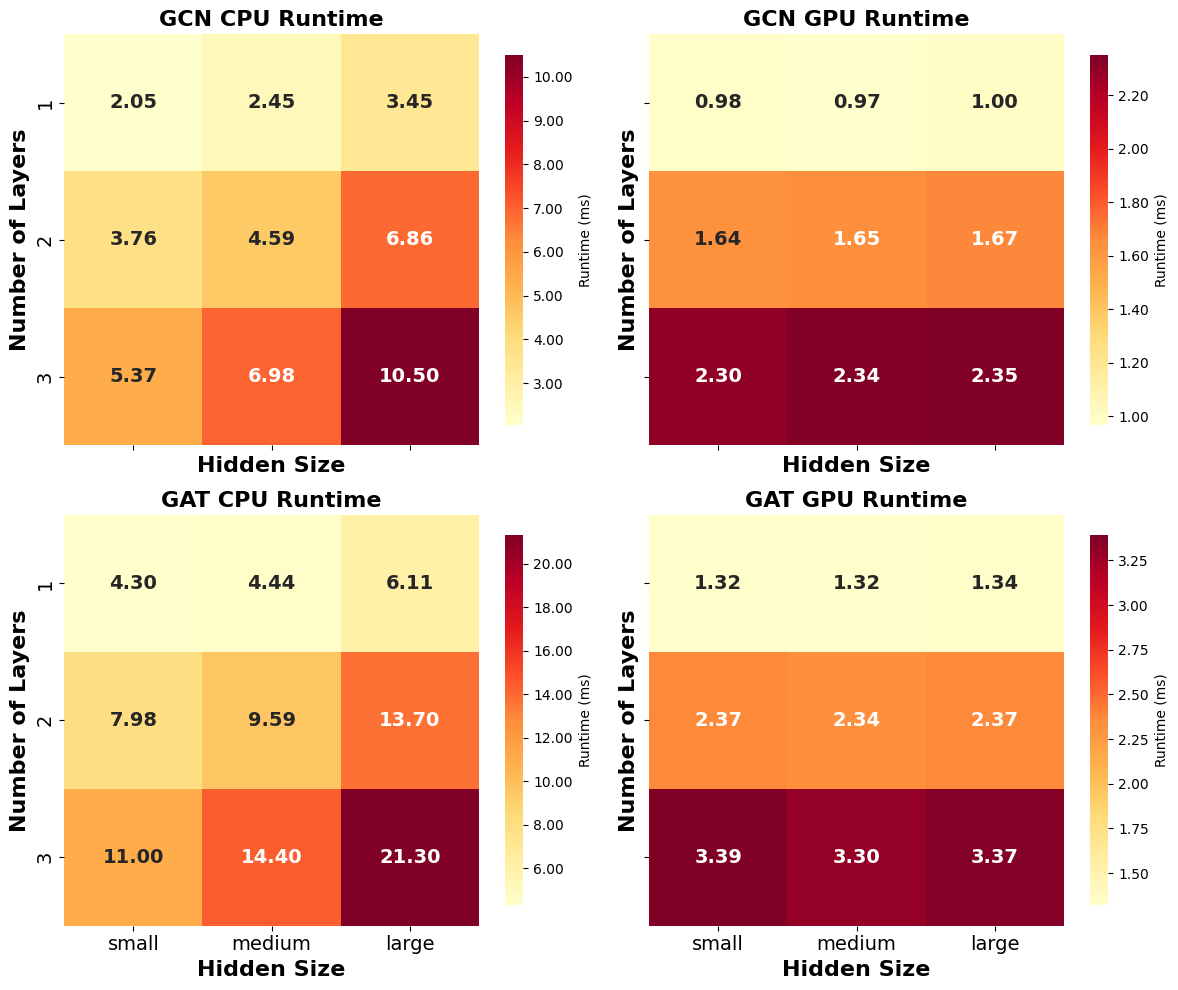

In [27]:
# for device in ["cpu", "cuda"]:
#     print(device)
#     for size_name, model_size in zip(["small", "medium", "large"], [32, 64, 128]):
#         for num_of_layers in [1, 2, 3]:
#             for model_type in ["gcn", "gat"]:
#                 configuration = f"{size_name}_{model_type}_layer_num_{num_of_layers}"
#                 model = GNN(num_layers=num_of_layers, hidden_dim=model_size, ff_dim=model_size, layer_type=model_type)
#                 model.to(device)
#                 for data in train_loader:
#                     print(f"Evaluating: {configuration} ", end="")
#                     x, edge_index, batch, y = data.x.to(device), data.edge_index.to(device), data.batch.to(device), data.y.to(device)
#                     %timeit model(x, edge_index, batch)
#                     break

model_data_rt = {
    "GCN": {
        "layers": {
            1: {
                "small": {"cpu": 2.05, "gpu": 0.982},
                "medium": {"cpu": 2.45, "gpu": 0.968},
                "large": {"cpu": 3.45, "gpu": 1},
            },
            2: {
                "small": {"cpu": 3.76, "gpu": 1.64},
                "medium": {"cpu": 4.59, "gpu": 1.65},
                "large": {"cpu": 6.86, "gpu": 1.67},
            },
            3: {
                "small": {"cpu": 5.37, "gpu": 2.3},
                "medium": {"cpu": 6.98, "gpu": 2.34},
                "large": {"cpu": 10.5, "gpu": 2.35},
            },
        }
    },
    "GAT": {
        "layers": {
            1: {
                "small": {"cpu": 4.3, "gpu": 1.32},
                "medium": {"cpu": 4.44, "gpu": 1.32},
                "large": {"cpu": 6.11, "gpu": 1.34},
            },
            2: {
                "small": {"cpu": 7.98, "gpu": 2.37},
                "medium": {"cpu": 9.59, "gpu": 2.34},
                "large": {"cpu": 13.7, "gpu": 2.37},
            },
            3: {
                "small": {"cpu": 11, "gpu": 3.39},
                "medium": {"cpu": 14.4, "gpu": 3.3},
                "large": {"cpu": 21.3, "gpu": 3.37},
            },
        }
    },
}

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_heatmap_data(model_data, model, device):
    # Get heatmap data for the selected model and device (CPU or GPU)
    layers = sorted(model_data[model]["layers"].keys())
    sizes = ["small", "medium", "large"]
    
    heatmap_data = []
    for layer in layers:
        row = [model_data[model]["layers"][layer][size][device] for size in sizes]
        heatmap_data.append(row)
        
    return np.array(heatmap_data), layers, sizes

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
for i, model in enumerate(["GCN", "GAT"]):
    for j, device in enumerate(["cpu", "gpu"]):
        data, layers, sizes = create_heatmap_data(model_data_rt, model, device)
        
        ax = axes[i, j]
        
        sns.heatmap(
            data, annot=True, fmt=".2f", cmap="YlOrRd", ax=ax,
            xticklabels=sizes, yticklabels=layers, 
            annot_kws={"size": 14, "weight": "bold"}, # Bold the millisecond values
            cbar_kws={'label': 'Runtime (ms)', 'format': '%.2f', 'shrink': 0.9}
        )
        
        ax.set_title(f"{model} {device.upper()} Runtime", fontsize=16, weight='bold')
        ax.set_xlabel("Hidden Size", fontsize=16, weight='bold')
        ax.set_ylabel("Number of Layers", fontsize=16, weight='bold')
        ax.tick_params(axis='both', labelsize=14)

plt.tight_layout()
#plt.savefig("Mean_Runtime_Over_7x100_iterations.png", dpi=300)
plt.show()

# Parameters

In [28]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

print("====================")
print("Number of parameters")
print("====================")
print()

for model_type in ["gcn", "gat"]:
    print(model_type)
    for num_of_layers in [1,2,3]:
        params = []
        for size_name, model_size in zip(["small", "medium", "large"], [32, 64, 128]):
            model = GNN(num_layers=num_of_layers, hidden_dim=model_size, ff_dim=model_size, layer_type=model_type)
            total, trainable = count_parameters(model)
            assert total == trainable
            params.append(total)
        print(f"\tLayers: {num_of_layers}: small({params[0]}) medium({params[1]}) large({params[2]})")

Number of parameters

gcn
	Layers: 1: small(855) medium(1687) large(3351)
	Layers: 2: small(1911) medium(5847) large(19863)
	Layers: 3: small(2967) medium(10007) large(36375)
gat
	Layers: 1: small(1975) medium(5975) large(20119)
	Layers: 2: small(4151) medium(14423) large(53399)
	Layers: 3: small(6327) medium(22871) large(86679)


# Regular NN

In [65]:
import torch
from torch.utils.data import Dataset

class MLPDataset(Dataset):
    def __init__(self, dataset: GraphDataset):
        self.dataset = dataset
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        data = self.dataset[idx]
        #one_hot_lbl = torch.zeros(self.num_classes)
        #one_hot_lbl[int(data.y)] = 1.0
        return data.x.reshape(42), data.y
    
    @property
    def num_classes(self):
        return self.dataset.num_classes

mlp_dataset = MLPDataset(dataset)
mlp_dataset[0]

(tensor([-0.0167,  1.0000, -0.5287,  0.6800, -0.5717,  0.2868, -0.2403, -0.0325,
          0.0147, -0.2924, -0.2454,  0.0657, -0.4922, -0.3443, -0.6272, -0.5873,
         -0.6840, -0.8051,  0.1775,  0.0744,  0.2880, -0.3975,  0.3231, -0.6547,
          0.4291, -0.8867,  0.5948,  0.1697,  0.1959, -0.0689, -0.1844,  0.1905,
         -0.2522,  0.3656,  1.0000,  0.3185,  0.4612,  0.1247,  0.1734,  0.3234,
          0.1847,  0.4700]),
 tensor(9))

In [66]:
from torch.utils.data import random_split, DataLoader
from torch.utils.data import DataLoader as TorchDataLoader

# Split lengths for train (80%), test (10%), valid (10%)
train_size = int(0.8 * len(mlp_dataset))
valid_size = int(0.1 * len(mlp_dataset))
test_size = len(mlp_dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(mlp_dataset, [train_size, valid_size, test_size])

BATCH_SIZE = 256
train_loader = TorchDataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = TorchDataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = TorchDataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# NOTE: Best model from preceding study (https://github.com/dancsomarci/sign-language)
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate=0.05):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(128, 16)
        self.fc4 = nn.Linear(16, output_dim)

    def forward(self, x):
        x = F.silu(self.fc1(x))  # swish activation
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.silu(self.fc3(x))  # swish activation
        x = F.softmax(self.fc4(x), dim=1)
        return x

mlp_model = MLP(input_dim=42, output_dim=mlp_dataset.num_classes)
total, trainable = count_parameters(mlp_model)
print(f"Total parameters: {total}")
print(f"Trainable parameters: {trainable}")
mlp_model

Total parameters: 46359
Trainable parameters: 46359


MLP(
  (fc1): Linear(in_features=42, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
  (fc3): Linear(in_features=128, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=23, bias=True)
)

In [91]:
# NOTE: Reusable train and eval loops for pure pytorch models

def train(model, loader, optimizer, criterion, device):
    total_loss = 0.0
    model.train()
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss/len(loader)

def evaluate(model, loader, criterion, device):
    correct = 0
    total_loss = 0.0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)

            loss = criterion(out, y)
            total_loss += loss.item()

            pred = out.argmax(dim=1)
            correct += int((pred == y).sum())

    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)

    return avg_loss, accuracy

In [ ]:
optimizer = torch.optim.Adam(mlp_model.parameters())
criterion = torch.nn.CrossEntropyLoss()

device = "cpu"
mlp_data = []
EPOCHS = 100
for epoch in range(1, EPOCHS+1):
    train_loss = mlp_train(mlp_model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = mlp_evaluate(mlp_model, valid_loader, criterion, device)
    test_loss, test_acc = mlp_evaluate(mlp_model, test_loader, criterion, device)
    
    mlp_data.append({
        'epoch': epoch,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'test_loss': test_loss,
        'test_acc': test_acc,
    })
    
    print(mlp_data[-1])

In [ ]:
cross_validate(
    get_new_model=lambda: MLP(input_dim=42, output_dim=mlp_dataset.num_classes),
    dataset=mlp_dataset,
    train_func=train,
    evaluate_func=evaluate,
    k=10,
    batch_size=256,
    epochs=2,
    loader=TorchDataLoader
)

## Custom GNNConv in PyTorch (optimized for mobile inference)

In [71]:
import torch
from torch.utils.data import Dataset

class PurePytorchGraphDataset(Dataset):
    def __init__(self, dataset: GraphDataset):
        self.dataset = dataset
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        data = self.dataset[idx]
        return data.x, data.y
    
    @property
    def num_classes(self):
        return self.dataset.num_classes

pp_graph_dataset = PurePytorchGraphDataset(dataset)
pp_graph_dataset[0]

(tensor([[-0.0167,  1.0000],
         [-0.5287,  0.6800],
         [-0.5717,  0.2868],
         [-0.2403, -0.0325],
         [ 0.0147, -0.2924],
         [-0.2454,  0.0657],
         [-0.4922, -0.3443],
         [-0.6272, -0.5873],
         [-0.6840, -0.8051],
         [ 0.1775,  0.0744],
         [ 0.2880, -0.3975],
         [ 0.3231, -0.6547],
         [ 0.4291, -0.8867],
         [ 0.5948,  0.1697],
         [ 0.1959, -0.0689],
         [-0.1844,  0.1905],
         [-0.2522,  0.3656],
         [ 1.0000,  0.3185],
         [ 0.4612,  0.1247],
         [ 0.1734,  0.3234],
         [ 0.1847,  0.4700]]),
 tensor(9))

In [73]:
from torch.utils.data import random_split, DataLoader

# Split lengths for train (80%), test (10%), valid (10%)
train_size = int(0.8 * len(pp_graph_dataset))
valid_size = int(0.1 * len(pp_graph_dataset))
test_size = len(pp_graph_dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(pp_graph_dataset, [train_size, valid_size, test_size])

BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [108]:
import torch
import torch.nn as nn
import torch.nn.functional as F

NUM_NODES = pp_graph_dataset[0][0].shape[0]
NUM_FEATURES = pp_graph_dataset[0][0].shape[1]
NUM_CATEGORIES = pp_graph_dataset.num_classes

class MobileGNNConv(nn.Module):
    """Custom implementation of GCN in Pytorch for Static ASL Fingerspelling sign classification.

    The implementation optimizes the general GCN by making the adjacency matrix, denoted 'A', a parameter.
    It also allows for optimizing the values of the said matrix via gradient descent and dynamically freezing the weights.
    """
    def __init__(self, input_dim: int, output_dim: int):
        super(MobileGNNConv, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lin = nn.Linear(input_dim, output_dim, bias=False)

        connections = anatomical_connections # assumed to contain A->B and B->A if undirected
        A = torch.zeros((NUM_NODES, NUM_NODES))
        for x, y in connections:
          A[x, y] = 1

        A_hat = A + torch.eye(A.size(0)) # self loops
        D = torch.diag(A_hat.sum(dim=1))
        D_neg_sqrt = torch.linalg.inv(torch.sqrt(D))
        A_norm = D_neg_sqrt @ A_hat @ D_neg_sqrt
        self.A_norm = nn.Parameter(A_norm, requires_grad=False) # Constant by default

    def set_adjancency(trainable: bool):
        self.A_norm.requires_grad = trainable

    def forward(self, X: torch.Tensor):
        # ReLU(D^-1/2 * A_hat * D^-1/2 * X * W)
        return F.relu(self.lin(self.A_norm @ X))

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.input_dim) + ' -> ' + str(self.output_dim) + ')'

class MobileGNN(nn.Module):
    def __init__(self, hidden_dim):
        super(MobileGNN, self).__init__()
        self.conv1 = MobileGNNConv(NUM_FEATURES, hidden_dim)
        self.conv2 = MobileGNNConv(hidden_dim, hidden_dim)
        self.lin = nn.Linear(hidden_dim, NUM_CATEGORIES)

    def set_adjancency(trainable: bool):
        self.conv1.set_adjancency(trainable)
        self.conv2.set_adjancency(trainable)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.mean(x, dim=1) # NOTE set 1 when there is a batch dimension
        x = self.lin(x)
        return x

mobile_gnn_model = MobileGNN(hidden_dim=128)
total, trainable = count_parameters(mobile_gnn_model)
print(f"Total parameters: {total}")
print(f"Trainable parameters: {trainable}")
display(mobile_gnn_model)

for x, y in train_loader:
    print(f"Output: {mobile_gnn_model(x).shape}")
    break

Total parameters: 20489
Trainable parameters: 19607


MobileGNN(
  (conv1): MobileGNNConv (2 -> 128)
  (conv2): MobileGNNConv (128 -> 128)
  (lin): Linear(in_features=128, out_features=23, bias=True)
)

Output: torch.Size([256, 23])


In [ ]:
optimizer = torch.optim.Adam(mobile_gnn_model.parameters())
criterion = torch.nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobile_gnn_model.to(device)
data = []
EPOCHS = 100
for epoch in range(1, EPOCHS+1):
    train_loss = train(mobile_gnn_model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(mobile_gnn_model, valid_loader, criterion, device)
    test_loss, test_acc = evaluate(mobile_gnn_model, test_loader, criterion, device)

    data.append({
        'epoch': epoch,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'test_loss': test_loss,
        'test_acc': test_acc,
    })
    
    print(data[-1])

In [ ]:
cross_validate(
    get_new_model=lambda: MobileGNN(hidden_dim=128),
    dataset=pp_graph_dataset,
    train_func=train,
    evaluate_func=evaluate,
    k=10,
    batch_size=256,
    epochs=2,
    loader=TorchDataLoader
)

In [ ]:
# TODO conversion and performance comparison after

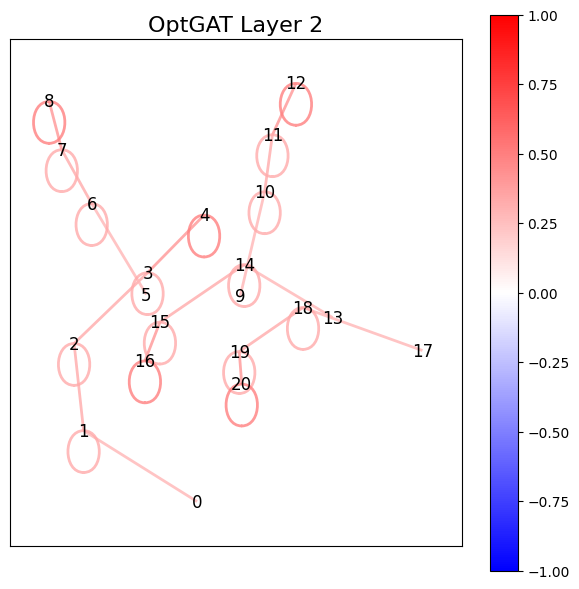

In [115]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def visualize_weighted_graph(node_features, adj_matrix, title="Weighted Graph Visualization", min_dev=0.25):
    node_features = node_features.cpu().numpy()
    adj_matrix = adj_matrix.cpu().numpy()

    assert adj_matrix.shape[0] == adj_matrix.shape[1]
    num_nodes = adj_matrix.shape[0]

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(title, fontsize=16)

    x = node_features[:, 0]
    y = node_features[:, 1]
    pos = {i: (x[i], y[i]) for i in range(len(x))}

    # Build the graph with weighted edges
    G = nx.Graph()
    for i in range(num_nodes):
        for j in range(num_nodes):
            weight = (adj_matrix[i, j] + adj_matrix[j, i]) / 2
            if abs(weight) > min_dev:
                G.add_edge(i, j, weight=weight)

    # Extract weights for coloring
    edges = G.edges(data=True)
    weights = np.array([d["weight"] for (_, _, d) in edges])

    # Normalize weights for coloring
    norm = plt.Normalize(vmin=-1, vmax=1) # optionally (vmin=weights.min(), vmax=weights.max())
    edge_colors = plt.cm.bwr(norm(weights))

    nx.draw_networkx_edges(G, pos, ax=ax, edge_color=edge_colors, width=2.0, alpha=0.8)
    nx.draw_networkx_labels(G, pos, {i: str(i) for i in range(len(x))}, font_size=12, font_color="black", ax=ax)

    ax.invert_yaxis()
    ax.set_aspect("equal", adjustable="box")
    # ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap="bwr"), ax=ax)
    plt.tight_layout()
    # plt.savefig("opt_gat_layer2.png", dpi=300)
    plt.show()

visualize_weighted_graph(pp_graph_dataset[0][0], mobile_gnn_model.conv2.A_norm, title="OptGAT Layer 2", min_dev=0.25)

## Comparison

In [26]:
mlp_df = pd.DataFrame(mlp_data)
mlp_df.to_csv("xy_only_mlp.csv", index=False)
mlp_df.head()

,epoch,train_loss,val_loss,val_acc,test_loss,test_acc
0,1,3.004393,2.856810,0.369334,2.850659,0.378647
1,2,2.796991,2.749651,0.486483,2.742100,0.494420
2,3,2.730750,2.708810,0.519435,2.704429,0.527363
3,4,2.702428,2.690563,0.529657,2.683384,0.542826
4,5,2.683538,2.674985,0.542972,2.666221,0.556273


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def compare_runs(df1, df2, col_name, label1='Run 1', label2='Run 2'):
    plt.figure(figsize=(16, 10))
    
    plt.plot(df1['epoch'], df1[col_name],  label=label1, linewidth=3.0)
    plt.plot(df2['epoch'], df2[col_name], label=label2, linewidth=3.0)


    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.xticks(range(0, df1['epoch'].values[-1]+1, 5))
    plt.legend()
    plt.grid()

    plt.show()

In [ ]:
compare_runs(mlp_df, graph_df, "val_acc", "MLP", "GNN")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def compare_runs(df1, df2, col_name, label1='Run 1', label2='Run 2'):
    plt.figure(figsize=(16, 5))
    
    # Use a color palette
    sns.set_palette("muted")
    
    # Plot both runs with different line styles
    plt.plot(df1['epoch'], df1[col_name], label=label1, linestyle='-', linewidth=3.0, marker='o', markersize=6)
    plt.plot(df2['epoch'], df2[col_name], label=label2, linestyle='-', linewidth=3.0, marker='s', markersize=6)
    
    # Add titles and labels
    #plt.title(f'Validation Accuracy Comparison\n{label1} vs. {label2}', fontsize=18, weight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Validation Accuracy', fontsize=14)
    
    # Mark max points for each run
    max_df1 = df1[col_name].idxmax()
    max_df2 = df2[col_name].idxmax()
    plt.scatter(df1['epoch'][max_df1], df1[col_name].max(), color='blue', s=20, zorder=5)
    plt.scatter(df2['epoch'][max_df2], df2[col_name].max(), color='orange', s=20, zorder=5)
    
    fs = 16
    plt.text(df1['epoch'][max_df1], df1[col_name].max(), f'{label1} Max: {df1[col_name].max():.4f}',
             ha='right', va='bottom', color='black', weight='bold', fontsize=fs)
    plt.text(df2['epoch'][max_df2], df2[col_name].max(), f'{label2} Max: {df2[col_name].max():.4f}',
             ha='right', va='bottom', color='black', weight='bold', fontsize=fs)
    
    # Optional: Add vertical lines at max epochs
    plt.axvline(x=df1['epoch'][max_df1], color='blue', linestyle=':', linewidth=1.5)
    plt.axvline(x=df2['epoch'][max_df2], color='orange', linestyle=':', linewidth=1.5)
    
    # Adjust x-ticks for readability
    plt.xticks(range(0, df1['epoch'].values[-1] + 1, 5))
    
    # Add legend and grid
    plt.legend(fontsize=16, loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout(rect=[0, 0, 1, 1.3])
    
    # Show plot
    plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# df1 = mlp_df
# df2 = gat_df
# df3 = gcn_df
# col_name = "val_acc"

# # plt.figure(figsize=(10, 5))

# # Use a color palette
# sns.set_palette("muted")

# # Calculate max values
# max_val_mlp = df1[col_name].max()
# max_val_gat = df2[col_name].max()
# max_val_gcn = df3[col_name].max()

# # Plot all three runs with max values in the legend
# plt.plot(df2['epoch'], df2[col_name], label=f"GAT (Max: {100*max_val_gat:.2f}%)", linestyle='-', linewidth=3.0, )
# plt.plot(df3['epoch'], df3[col_name], label=f"GCN (Max: {100*max_val_gcn:.2f}%)", linestyle='-', linewidth=3.0, )
# plt.plot(df1['epoch'], df1[col_name], label=f"MLP (Max: {100*max_val_mlp:.2f}%)", linestyle='-', linewidth=3.0, )

# # Add axis labels
# plt.xlabel('Epoch', fontsize=14)
# plt.ylabel('Validation Accuracy', fontsize=14)

# # Mark max points for each run and add vertical lines
# max_df1 = df1[col_name].idxmax()
# max_df2 = df2[col_name].idxmax()
# max_df3 = df3[col_name].idxmax()

# # Define colors
# orange = (238/255, 133/255, 74/255)
# green = (106/255, 200/255, 100/255)
# blue = (72/255, 120/255, 208/255)

# # Plot scatter points for max values
# # plt.scatter(df1['epoch'][max_df1], max_val_mlp, color=blue, s=40, zorder=5)
# # plt.scatter(df2['epoch'][max_df2], max_val_gat, color=orange, s=40, zorder=5)
# # plt.scatter(df3['epoch'][max_df3], max_val_gcn, color=green, s=40, zorder=5)

# # Add vertical lines at max epochs
# # plt.axvline(x=df1['epoch'][max_df1], color=blue, linestyle=':', linewidth=3)
# # plt.axvline(x=df2['epoch'][max_df2], color=orange, linestyle=':', linewidth=3)
# # plt.axvline(x=df3['epoch'][max_df3], color=green, linestyle=':', linewidth=3)

# # Adjust x-ticks for readability
# plt.xticks(range(0, df1['epoch'].values[-1] + 1, 5))
# #plt.ylim(0.5, 1.02)

# # Add legend and grid
# plt.legend(fontsize=14, loc='lower right')
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.tight_layout()

# # Show plot
# plt.savefig("valid_run.png", dpi=300)
# plt.show()

In [29]:
model.eval()

MLP(
  (fc1): Linear(in_features=42, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
  (fc3): Linear(in_features=128, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=23, bias=True)
)

In [ ]:
torch.save(model.state_dict(), "test_model.pth")

In [ ]:
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH, weights_only=True))
model.eval()